# SYDE 556/750: Simulating Neurobiological Systems

## Administration

- 2-slide presentations on project topics
- Mar 30th: Castricato, Guliani, Stoeckel, Tolooshams, Bradshaw, Reyes, Griffin, Zheng, Lee, Nguyen, Raghavan, Thompson 
- Apr 3rd: Ganjidoost, Noukhovitch, Pacheco, Abarca, Lambert, Tsatskin, Barnard, Ansari, Kahn, Orr, 

## Memory

Readings: [Serial Working Memory](http://compneuro.uwaterloo.ca/files/publications/choo.2010a.pdf); [Associative Memory](http://compneuro.uwaterloo.ca/files/publications/stewart.2011.pdf)

- We've seen how to represent symbol-like structures using vectors
- Typically high dimensional vectors
- How can we store those over short periods of time (working memory)
- Long periods of time?
- Recall Jackendoff's 4th challenge (same repn in long and working memory)

## Attractor networks
- An attractor in dynamical systems theory is a system state (or states) towards which other states tend over time
- The standard analogy is to imagine the state space as a ‘hill-like’ topology which a ball travels through (tending downhill).

<img src="lecture_memory/point_attractor.png" width="500">

- In neural network research, attractor networks (networks with dynamical attractors) have long been thought relevant for various behaviours 
    - e.g., memory, integration, off-line updating of representations, repetitive pattern generation, noise reduction, etc.


    
- The neural integrator is an example of an attractor network

- The neural integrator can be thought of as a line attractor as in a) 
    - Actually an approximate one as in b)

<img src="lecture_memory/line_attractor.png" width="600">

- Attractor networks were extensively examined in the ANN community (e.g. hopfield nets). Amit suggested that persistent activity could be associated with recurrent biological networks 
- Persistent activity is found in motor, premotor, parietal, prefrontal, frontal, hippocampal, and inferotemporal cortex; and basal ganglia, midbrain, superior colliculus, and brainstem
- Focus to date is often on simple attractors:
    - The NEF lets us easily generalize.

## Generalizing dynamics

- A cyclic attractor (i.e. a set of attractive points that the system moves through)

<img src="lecture_memory/cyclic_attractor.png" width="600">

- Note: The hill and ball analogy doesn't work anymore.

- This is an oscillator.  Technically a nonlinear one, since it should be stable (the Simple Harmonic Oscillator is linear).  Let's build a stable oscillator.

In [33]:
%pylab inline
import nengo
from nengo.utils.ensemble import response_curves
from nengo.dists import Uniform

model = nengo.Network('Oscillator')

freq = .25
scale = 1.1
N=300

with model:
    stim = nengo.Node(lambda t: [.5,.5] if .1<t<.12 else [0,0])
    inhib = nengo.Node(lambda t: [-1]*N if .8<t<.82 else [0]*N)
    
    osc = nengo.Ensemble(N, dimensions=2, intercepts=Uniform(.3,1))
    
    def feedback(x):
        return scale*x[0]+freq*x[1], -freq*x[0]+scale*x[1]
    
    nengo.Connection(osc, osc, function=feedback)
    nengo.Connection(inhib, osc.neurons)
    nengo.Connection(stim, osc)
    
    osc_p = nengo.Probe(osc, synapse=.01)
    

`%matplotlib` prevents importing * from pylab and numpy


In [34]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/nonlinear_oscillator.py.cfg")

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


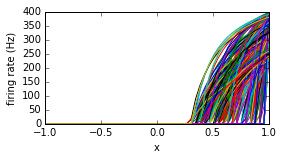

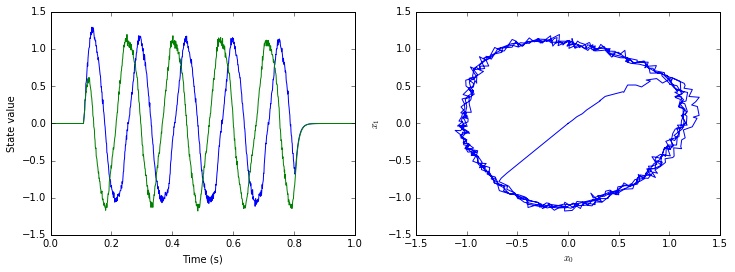

In [3]:
sim = nengo.Simulator(model)
sim.run(1)

x, A = response_curves(osc, sim)
figure(figsize=(4,2))
plot(x, A)
xlabel('x')
ylabel('firing rate (Hz)')

figure(figsize=(12,4))
subplot(1,2,1)
plot(sim.trange(), sim.data[osc_p]);
xlabel('Time (s)')
ylabel('State value')
       
subplot(1,2,2)
plot(sim.data[osc_p][:,0],sim.data[osc_p][:,1])
xlabel('$x_0$')
ylabel('$x_1$');

- This also generalizes to chaotic attractors and many other fun dynamic networks (see Lecture 5).
- Can also generalize representation

## Generalizing representation

- Generalizing a line attractor gives something much more interesting
    - A plane attractor
    
<img src="lecture_memory/plane_attractor.png" width="600">

- The attractor space is much more complicated, so you need a lot more neurons to do as good a job ($N^D$)

Populating the interactive namespace from numpy and matplotlib
Building finished in 0:00:01.                                                   


`%matplotlib` prevents importing * from pylab and numpy


Simulating finished in 0:00:01.                                                 


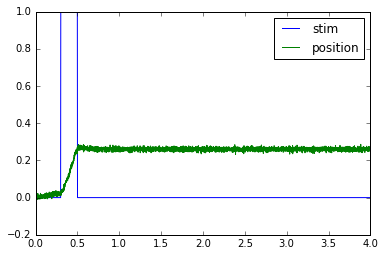

In [7]:
%pylab inline
#A 1D integrator with a few hundred neurons works great
import nengo
from nengo.utils.functions import piecewise

model = nengo.Network(label='1D Line Attractor', seed=5)

N = 300
tau = 0.01

with model:
    stim = nengo.Node(piecewise({.3:[1], .5:[0] }))
    neurons = nengo.Ensemble(N, dimensions=1)

    nengo.Connection(stim, neurons, transform=tau, synapse=tau)
    nengo.Connection(neurons, neurons, synapse=tau)

    stim_p = nengo.Probe(stim)
    neurons_p = nengo.Probe(neurons, synapse=.01)
    
sim = nengo.Simulator(model)
sim.run(4)

t=sim.trange()

plot(t, sim.data[stim_p], label = "stim")
plot(t, sim.data[neurons_p], label = "position")
legend(loc="best");

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


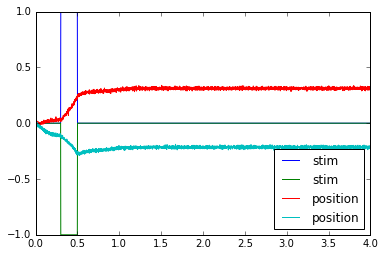

In [18]:
#Need lots of neurons to get reasonable performance in higher D
import nengo
from nengo.utils.functions import piecewise

model = nengo.Network(label='2D Plane Attractor', seed=4)

N = 2000 #100
tau = 0.01

with model:
    stim = nengo.Node(piecewise({.3:[1, -1], .5:[0, 0] }))
    neurons = nengo.Ensemble(N, dimensions=2)

    nengo.Connection(stim, neurons, transform=tau, synapse=tau)
    nengo.Connection(neurons, neurons, synapse=tau)

    stim_p = nengo.Probe(stim)
    neurons_p = nengo.Probe(neurons, synapse=.01)
    
sim = nengo.Simulator(model)
sim.run(4)

t=sim.trange()

plot(t, sim.data[stim_p], label = "stim")
plot(t, sim.data[neurons_p], label = "position")
legend(loc="best");

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


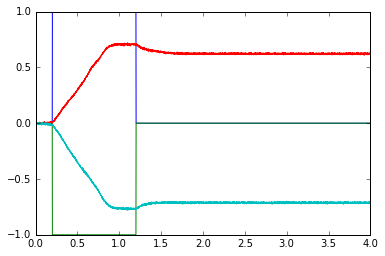

In [16]:
#Note that the representation saturates at the radius
with model:
    stim.output = piecewise({.2:[1, -1], 1.2:[0, 0] })
    
sim = nengo.Simulator(model)
sim.run(4)

t=sim.trange()

plot(t, sim.data[stim_p], label = "stim")
plot(t, sim.data[neurons_p], label = "position");

- So for higher dimensional memories, you may want the dimensions to be independent
    - To make this easy, Nengo has 'ensemble arrays'

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


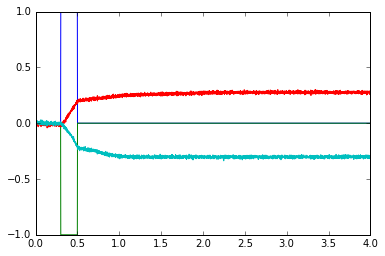

In [20]:
model = nengo.Network(label='Ensemble Array', seed=123)

N = 300
tau = 0.01

with model:
    stim = nengo.Node(piecewise({.3:[1, -1], .5:[0, 0] }))

    neurons = nengo.networks.EnsembleArray(N, n_ensembles=2)
    
    nengo.Connection(stim, neurons.input, transform=tau, synapse=tau)
    nengo.Connection(neurons.output, neurons.input, synapse=tau)

    stim_p = nengo.Probe(stim)
    neurons_p = nengo.Probe(neurons.output, synapse=.01)
    
sim = nengo.Simulator(model)
sim.run(4)

t=sim.trange()

plot(t, sim.data[stim_p], label = "stim")
plot(t, sim.data[neurons_p], label = "position");

In [23]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/ensemble_array.py.cfg")

- And saturation effects are quite different

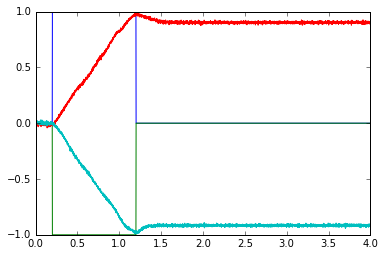

In [24]:
#Note that the representation saturates at the radius
with model:
    stim.output = piecewise({.2:[1, -1], 1.2:[0, 0] })
    
sim = nengo.Simulator(model)
sim.run(4)

t=sim.trange()

plot(t, sim.data[stim_p], label = "stim")
plot(t, sim.data[neurons_p], label = "position");

## Working memory

- We can build high dimensional working memories using plane attractors
- In general we want some saturation, and some independence between dimensions
    - Gives both a 'soft normalization' 
    - And good temporal stability for fewer neurons


//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


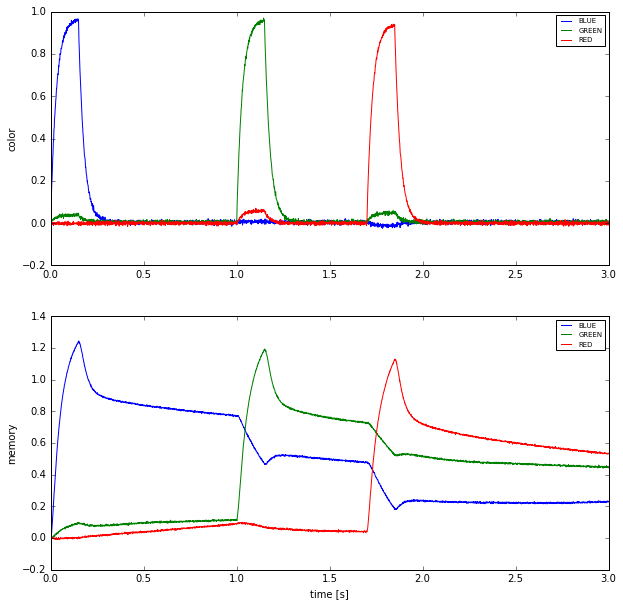

In [25]:
import nengo
from nengo import spa

def color_input(t):
    if t < 0.15:
        return 'BLUE'
    elif 1.0 < t < 1.15:
        return 'GREEN'
    elif 1.7 < t < 1.85:
        return 'RED'
    else:
        return '0'

model = spa.SPA(label="HighD Working Memory", seed=5)

dimensions = 32

with model:
    model.color_in = spa.Buffer(dimensions=dimensions)

    model.mem = spa.Memory(dimensions=dimensions, subdimensions=4, 
                           synapse=0.1, neurons_per_dimension=50)

    # Connect the buffers
    cortical_actions = spa.Actions(
        'mem = color_in'
    )
    
    model.cortical = spa.Cortical(cortical_actions) 

    model.inp = spa.Input(color_in=color_input)
    
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    color_in = nengo.Probe(model.color_in.state.output)
    mem = nengo.Probe(model.mem.state.output)
    
sim = nengo.Simulator(model)
sim.run(3.)

plt.figure(figsize=(10, 10))
vocab = model.get_default_vocab(dimensions)

plt.subplot(2, 1, 1)
plt.plot(sim.trange(), model.similarity(sim.data, color_in))
plt.legend(model.get_output_vocab('color_in').keys, fontsize='x-small')
plt.ylabel("color")

plt.subplot(2, 1, 2)
plt.plot(sim.trange(), model.similarity(sim.data, mem))
plt.legend(fontsize='x-small')
plt.legend(model.get_output_vocab('color_in').keys, fontsize='x-small')
plt.ylabel("memory")
plt.xlabel("time [s]");

In [26]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/simple_spa_wm.py.cfg")

In [27]:
# model.all_ensembles has all the neurons

model.all_ensembles[2].n_neurons

200

- You can see interference effects here
- If you recalled things from this memory, you'd probably have a 'recency effect'
    - i.e. The things most recently put in memory would be best recalled

- This is seen in human memory, but so is primacy
    - How could we get primacy?  

In [28]:
import nengo
from nengo import spa

def color_input(t):
    if t < 0.15:
        return 'BLUE'
    elif 1.0 < t < 1.15:
        return 'GREEN'
    elif 1.7 < t < 1.85:
        return 'RED'
    else:
        return '0'

model = spa.SPA(label="HighD Working Memory", seed=5)

dimensions = 32

with model:
    model.color_in = spa.Buffer(dimensions=dimensions)

    model.mem = spa.Memory(dimensions=dimensions, subdimensions=4, 
                           synapse=0.1, neurons_per_dimension=50, 
                           tau=-.2)

    # Connect the buffers
    cortical_actions = spa.Actions(
        'mem = color_in'
    )
    
    model.cortical = spa.Cortical(cortical_actions) 

    model.inp = spa.Input(color_in=color_input)
    
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    color_in = nengo.Probe(model.color_in.state.output)
    mem = nengo.Probe(model.mem.state.output)


In [29]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/simple_spa_wm_primacy.py.cfg")

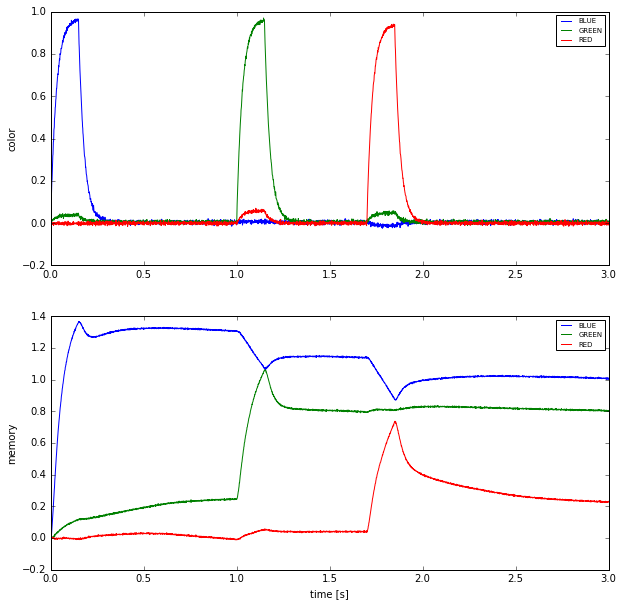

In [30]:
sim = nengo.Simulator(model)
sim.run(3.)

plt.figure(figsize=(10, 10))
vocab = model.get_default_vocab(dimensions)

plt.subplot(2, 1, 1)
plt.plot(sim.trange(), model.similarity(sim.data, color_in))
plt.legend(model.get_output_vocab('color_in').keys, fontsize='x-small')
plt.ylabel("color")

plt.subplot(2, 1, 2)
plt.plot(sim.trange(), model.similarity(sim.data, mem))
plt.legend(fontsize='x-small')
plt.legend(model.get_output_vocab('color_in').keys, fontsize='x-small')
plt.ylabel("memory")
plt.xlabel("time [s]");

- By making tau negative, we forced the recurrent connection to be positive
    - So, whatever is in memory 'grows' over time
- This gives a 'primacy' effect
    - i.e. Whatever you ran into first is what you remember
    - You could also get this by changing connection weights    


- Together, primacy and recency capture the most salient properties of human working memory
- You see these effects in both 'free recall' and 'serial recall'

<img src="lecture_memory/human_wm.png" width="400">

- So far, the networks we've seen would work well for free recall presumably.
    - How to include order information?

## Serial Working Memory

- An ordered list is a very simple kind of structure
- To represent structures, we can use what we learned last time: vector binding
    - Specifically, Semantic Pointers
    
- In this case, we can do something like:

$Pos_0\circledast Item_0 + Pos_1\circledast Item_1 + ...$

- The $Item$ can just whatever vector we want to remember
- How should we generate $Pos$?  What features does it need?
    - It would be good if we could generate them on the fly, forever
    - It would be good if $Pos_0$ "came before" $Pos_1$ in some sense

    

- There is a kind of vector that's ideal for this called a 'unitary vector'
    - A unitary vector does not change length when convolved
        - So, you can convolve forever
    - The convolution of a unitary vector with itself is 'unlike' the original vector
        - So, you can go fwd/backward with convolution/correlation
- This gives a way of 'counting' positions:
    - $Pos_0 \circledast PlusOne = Pos_1$
    - $Pos_1 \circledast PlusOne = Pos_2$
    - $Pos_2 \circledast PlusOne = Pos_3$
    - etc.
    - And, $Pos_3 \circledast PlusOne' = Pos_2$


- We can put this representation together with primacy and recency, and we get something like this

<img src="lecture_memory/wm_model.png">

- To do 'recall' from this representation, we want to remember what we've already recalled, so we can add a circuit like this

<img src="lecture_memory/wm_recall.png">



- This does a pretty good job of capturing lots of working memory data

<img src="lecture_memory/model_data1.png">



- Order effects

<img src="lecture_memory/model_data2.png">



- Error probability of items in the list (closer items are more likely to be incorrect, unless you change similarity between items)

<img src="lecture_memory/model_data3.png">





- Item similarity effects

<img src="lecture_memory/model_data4.png">



- Arbitrary list lengths

- This model can actually do lots more as well
    - backwards recall, etc.
- A slight variation does free recall
    - you have to include non-bound item representations as well
- You'll notice that it relies on a 'clean-up' 
    - This is a kind of long term memory
    - We saw this show up before when talking about symbols
    - How can we build such a thing in spiking neurons?

## Long term memory


- In order for memories to be stable over the long term, they must be encoded in connection weights
- These kind of memories are often called 'associative memories'
    - Auto-associative: recall the same thing you're shown
        - e.g. for noise reduction
        - pattern completion
    - Hetero-associative: recall some arbitrary association
        - e.g. for capturing domain relationships
        - reasoning
        


- Typical solutions in ANNs are 
    - Hopfield networks: A many-point attractor network
    - Linear associators: Do SVD on the input/output to get a weight matrix
    - Multi-layer Perceptron (MLP): Use backprop to train a network to compute the feedfwd mapping

<img src="lecture_memory/hopfield.png">




- Often worried about how to learn these
    - We'll talk about learning in a later lecture
    - Often the learning is so un-'biologically plausible' that it's best thought of as an optimization (like least squares in the NEF).
    
- How to compute these kinds of mappings with the NEF/SPA?
    - We want to 'recognize' specific vectors (in a vocabulary)
    - We want only some neurons to fire when a given vector is present (sparse)
    - We want to activate a given output vector if the input is recognized
    


- Can do it in one layer with a feedforward approach
    - Set the encoding vectors of some small set of neurons to be a vocabulary item
        - That will pick out specific vectors
    - Set the intercepts of neurons to be high in the positive direction
        - So they will only fire if there is 'enough' of that vector in the input
    - Set the linear transformation on the output of those neurons to be the desired output vector
        - Since these are in the weights, the output will perfectly represent the desired output
        
- We've seen several techniques that will make this easy
    - Ensemble arrays: For collecting lots of small populations together
    - SPA module: For defining vocabs, etc.

In [31]:
import nengo
from nengo import spa

seed=1
np.random.seed(seed)
model = spa.SPA("Associative Memory", seed=seed)

D = 32
vocab = spa.Vocabulary(D)
vocab.parse('BLUE+GREEN+RED')

noise_RED = vocab.parse("RED").v + .2*np.random.randn(D)
noise_RED = noise_RED/np.linalg.norm(noise_RED)

noise_GREEN = vocab.parse("GREEN").v + .2*np.random.randn(D)
noise_GREEN = noise_GREEN/np.linalg.norm(noise_GREEN)

def memory_input(t):
    if t < 0.2:
        return vocab.parse("BLUE").v
    elif .2 < t < .5:
        return noise_RED
    elif .5 < t < .8:
        return vocab.parse("RED").v
    elif .8 < t < 1:
        return noise_GREEN
    else:
        return vocab.parse("0").v

with model:
    stim = nengo.Node(output=memory_input, label='input')
    model.am = spa.AssociativeMemory(vocab)
    nengo.Connection(stim, model.am.input)

    in_p = nengo.Probe(stim)
    out_p = nengo.Probe(model.am.output, synapse=0.03)



In [32]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/simple_cleanup.py.cfg")

In [ ]:
sim = nengo.Simulator(model)
sim.run(1)
t = sim.trange()

figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(t, spa.similarity(sim.data[in_p], vocab))
plt.ylabel("Input")
plt.ylim(top=1.1)
plt.legend(vocab.keys, loc='best')
plt.subplot(2, 1, 2)
plt.plot(t, nengo.spa.similarity(sim.data[out_p], vocab))
plt.ylabel("Output")
plt.legend(vocab.keys, loc='best');

- This implementation has several nice features
    - Extremely fast (1 synapse feedforward ~ 5ms)
    - Fully spiking, integrates with SPA models
    - Scales very well
    
<img src="lecture_memory/cleanup.png" width="500">

- Scaling properties of a neural clean-up memory. 
    - A SP is formed by binding $k$ pairs of random SPs and adding 
    - Binding to random probes from that set. 
    - Figure shows the minimum number of dimensions required to recover a lexical item from the input 99% of the time. 
    - Averages over 200 simulations for each combination of $k$, $M$, and $D$ values. 
    - Vertical dashed line is approximate size of an adult lexicon. 
    - Horizontal dashed lines show the performance of a non-neural clean-up directly implementing the algorithm.

## SPA Example

- This is the same example as for the symbols lecture, but with a working memory
    - The WM is just a single attractor network
    - The model is supposed to memorize the bound inputs and then answer questions about what is bound to what

In [33]:
%pylab inline
import nengo
from nengo import spa

def color_input(t):
    if t < 0.25:
        return 'RED'
    elif t < 0.5:
        return 'BLUE'
    else:
        return '0'

def shape_input(t):
    if t < 0.25:
        return 'CIRCLE'
    elif t < 0.5:
        return 'SQUARE'
    else:
        return '0'

def cue_input(t):
    if t < 0.5:
        return '0'
    sequence = ['0', 'CIRCLE', 'RED', '0', 'SQUARE', 'BLUE']
    idx = int(((t - 0.5) // (1. / len(sequence))) % len(sequence))
    return sequence[idx]

seed=1
model = spa.SPA(label="Simple question answering", seed=seed)

dimensions = 32
vocab = model.get_default_vocab(dimensions)
vocab.parse('BLUE+RED+CIRCLE+SQUARE')

with model:    
    model.color_in = spa.Buffer(dimensions=dimensions)
    model.shape_in = spa.Buffer(dimensions=dimensions)
    model.conv = spa.Memory(dimensions=dimensions, subdimensions=4, synapse=0.4)
    model.cue = spa.Buffer(dimensions=dimensions)
    model.out = spa.Buffer(dimensions=dimensions)
    model.am = spa.AssociativeMemory(vocab, threshold=0.1)

    model.inp = spa.Input(color_in=color_input, shape_in=shape_input, cue=cue_input)
    
    # Connect the buffers
    cortical_actions = spa.Actions(
        'conv = color_in * shape_in',
        'out = conv * ~cue',
        'am = out'
    )
    model.cortical = spa.Cortical(cortical_actions)  
    
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    color_in = nengo.Probe(model.color_in.state.output)
    shape_in = nengo.Probe(model.shape_in.state.output)
    cue = nengo.Probe(model.cue.state.output)
    conv = nengo.Probe(model.conv.state.output)
    out = nengo.Probe(model.out.state.output)
    clean = nengo.Probe(model.am.output)
    


`%matplotlib` prevents importing * from pylab and numpy


In [34]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/binding_with_memory.py.cfg")

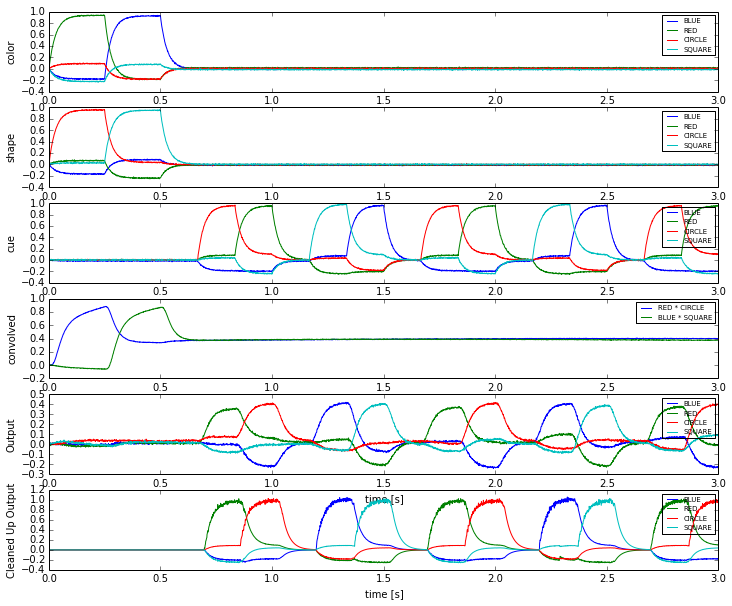

In [66]:
sim = nengo.Simulator(model)
sim.run(3.)

plt.figure(figsize=(12, 10))

plt.subplot(6, 1, 1)
plt.plot(sim.trange(), model.similarity(sim.data, color_in))
plt.legend(model.get_output_vocab('color_in').keys, fontsize='x-small')
plt.ylabel("color")

plt.subplot(6, 1, 2)
plt.plot(sim.trange(), model.similarity(sim.data, shape_in))
plt.legend(model.get_output_vocab('shape_in').keys, fontsize='x-small')
plt.ylabel("shape")

plt.subplot(6, 1, 3)
plt.plot(sim.trange(), model.similarity(sim.data, cue))
plt.legend(model.get_output_vocab('cue').keys, fontsize='x-small')
plt.ylabel("cue")

plt.subplot(6, 1, 4)
for pointer in ['RED * CIRCLE', 'BLUE * SQUARE']:
    plt.plot(sim.trange(), vocab.parse(pointer).dot(sim.data[conv].T), label=pointer)
plt.legend(fontsize='x-small')
plt.ylabel("convolved")

plt.subplot(6, 1, 5)
plt.plot(sim.trange(), spa.similarity(sim.data[out], vocab))
plt.legend(model.get_output_vocab('out').keys, fontsize='x-small')
plt.ylabel("Output")
plt.xlabel("time [s]");

plt.subplot(6, 1, 6)
plt.plot(sim.trange(), spa.similarity(sim.data[clean], vocab))
plt.legend(model.get_output_vocab('am').keys, fontsize='x-small')
plt.ylabel("Cleaned Up Output")
plt.xlabel("time [s]");